### Imports + Data Loading

In [1]:
# import methods from bertviz
from bertviz import neuron_view
from bertviz.transformers_neuron_view import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer

import numpy as np
import random
import string
import pickle

from numpy import linalg as LA
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
import random

from collections import defaultdict

In [2]:
sentences = np.load('saved/sentences.npy') # load sentences from Catherine's file
# sentences_test = sentences[:10] # small sample to test out code with

### Select BERT or GPT

In [4]:
# # BERT
# model_type = 'bert'
# model_version = 'bert-base-uncased'
# model = BertModel.from_pretrained(model_version, output_attentions=True)
# tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=True)

# GPT
model_type = 'gpt2'
model_version = 'gpt2'
model = GPT2Model.from_pretrained(model_version, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_version, do_lower_case=True)

num_heads = 12
num_layers = 12

## Correlation Analysis

In [9]:
# corr_info = {'dot_prod': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
#              'dist': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)],
#              'corr': [[[''.join(random.choices(string.ascii_letters, k=5))] for i in range(num_heads)] for j in range(num_layers)]}

In [5]:
# helper function for finding distance between two vectors
def distance(list1, list2):
    squares = [(p-q) ** 2 for p, q in zip(list1, list2)]
    return sum(squares) ** .5

# try cosine distance?

### Computing original correlations between dot product and distance (before scaling)

In [75]:
corr_list = [[list() for i in range(num_heads)] for j in range(num_layers)]
original_corr = [[0 for i in range(num_heads)] for j in range(num_layers)]

token_count = 0
for s in sentences[0:100]:
    # call method from bertviz to get attention info
    s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
    
    for i in range(num_heads):
        for j in range(num_layers):
            query = s_dict['queries'][i][j]
            key = s_dict['keys'][i][j]
            
            for q in query:
                token_level_dp = []
                token_level_dist = []
                for k in key:
                    # compute token-level dp and distances
                    token_level_dp.append(np.dot(q, k))
                    token_level_dist.append(distance(q, k))
                
                corr_list[i][j].append(np.corrcoef(token_level_dp, token_level_dist)[0][1])
                original_corr[i][j] += np.corrcoef(token_level_dp, token_level_dist)[0][1]
                total += 1
        
original_corr = [[original_corr[i][j] / total * (num_heads*num_layers) for i in range(num_heads)] for j in range(num_layers)]

In [253]:
import matplotlib.colors as colors

# Create 12x12 heatmap of average correlation per head
fig, ax = plt.subplots(figsize=(8, 6), dpi = 150)
norm = colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
s = sns.heatmap(original_corr, fmt="",cmap='RdBu',linewidths=0.50,ax=ax, norm = norm)
s.set_xlabel('Layer', fontsize=13)
s.set_ylabel('Head', fontsize=13)
plt.title('Original Token-Level Correlation Between Dot Product and Distance', fontsize = 14)

### Compute correlations for different scaling constants

In [258]:
# corr_list = [[list() for i in range(num_heads)] for j in range(num_layers)]
# corr = [[0 for i in range(num_heads)] for j in range(num_layers)]
# corr_scaling = [[dict() for i in range(num_heads)] for j in range(num_layers)]

corr_scaling = [[defaultdict(float) for i in range(num_heads)] for j in range(num_layers)]
# scaling_consts = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1/0.8, 1/0.6, 1/0.4, 1/0.2]
# scaling_consts = [0.01, 0.1]

for scale in scaling_consts:
    token_count = 0
    
    for s in sentences[0:100]:
        s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
        
        for i in range(num_heads):
            for j in range(num_layers):
                query = s_dict['queries'][i][j]
                key = s_dict['keys'][i][j]

                for q in query:
                    dp_scaled = []
                    dist_scaled = []
                    for k in key:
                        # compute scaled q + k
                        q_scaled = [x / scale for x in q]
                        k_scaled = [x * scale for x in k]
                        
                        # compute dp + distance
                        dp_scaled.append(np.dot(q_scaled, k_scaled))
                        dist_scaled.append(distance(q_scaled, k_scaled))
                
                    # compute correlation
                    corr_scaling[i][j][scale] += np.corrcoef(dp_scaled, dist_scaled)[0][1]
                    token_count += 1
   
    for i in range(num_heads):
        for j in range(num_layers):
            corr_scaling[i][j][scale] = corr_scaling[i][j][scale] /token_count * (num_heads * num_layers)

In [ ]:
# Identify optimal constant per head
optimized_scale = [[int for i in range(num_heads)] for j in range(num_layers)]

for i in range(num_heads):
    for j in range(num_layers):
        optimized_scale[i][j] = min(corr_scaling[i][j], key = corr_scaling[i][j].get)

In [264]:
# Save results

# save scaling constant correlation results
# corr_scaling_orig = np.array(corr_scaling)

with open('saved/corr_scaling_orig.npy', 'wb') as f:
    np.save(f, corr_scaling_orig)
    
# save new (0.01, 0.1) scaling constant correlation results
# corr_scaling_small = np.array(corr_scaling)

with open('saved/corr_scaling_small.npy', 'wb') as f:
    np.save(f, corr_scaling_small)

In [266]:
# list_data2 = np.transpose(np.array([list(corr_scaling[0][0].keys()), list(list(corr_scaling[0][0].values()))]))

In [247]:
# Show results in df table
list_data = np.transpose(np.array([list(corr_scaling[0][0].keys()), list(list(corr_scaling[0][0].values()))]))
df = pd.DataFrame(list_data, columns = ['Scaling Constant', 'Correlation'])
df['Scaling Constant'] = df['Scaling Constant'].round(1)
df['Correlation'] = df['Correlation'].round(3)
df

,Scaling Constant,Correlation
0,0.2,-0.998
1,0.4,-0.972
2,0.6,-0.899
3,0.8,-0.797
4,1.0,-0.699
5,1.2,-0.605
6,1.7,-0.510
7,2.5,-0.427
8,5.0,-0.373


### Visualizing dp + dist distributions

In [288]:
# scaling_consts = [0.2, 0.4, 0.6, 0.8, 1, 1/0.8, 1/0.6, 1/0.4, 1/0.2]
scaling_consts = [1]

all_dp = [[list() for i in range(num_heads)] for j in range(num_layers)]
all_dist = [[list() for i in range(num_heads)] for j in range(num_layers)]

for scale in scaling_consts:
    token_count = 0
    print('SCALE:', scale)
    
    for s in sentences[0:10]:
        s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
        
        for i in range(num_heads):
            for j in range(num_layers):
                query = s_dict['queries'][i][j]
                key = s_dict['keys'][i][j]

                for q in query:
#                     dp_scaled = []
#                     dist_scaled = []
                    for k in key:
                        # compute scaled q + k
                        q_scaled = [x / scale for x in q]
                        k_scaled = [x * scale for x in k]
                        
                        # compute dp + distance
                        all_dp[i][j].append(np.dot(q_scaled, k_scaled))
                        all_dist[i][j].append(distance(q_scaled, k_scaled))

SCALE: 1


<Figure size 432x288 with 0 Axes>

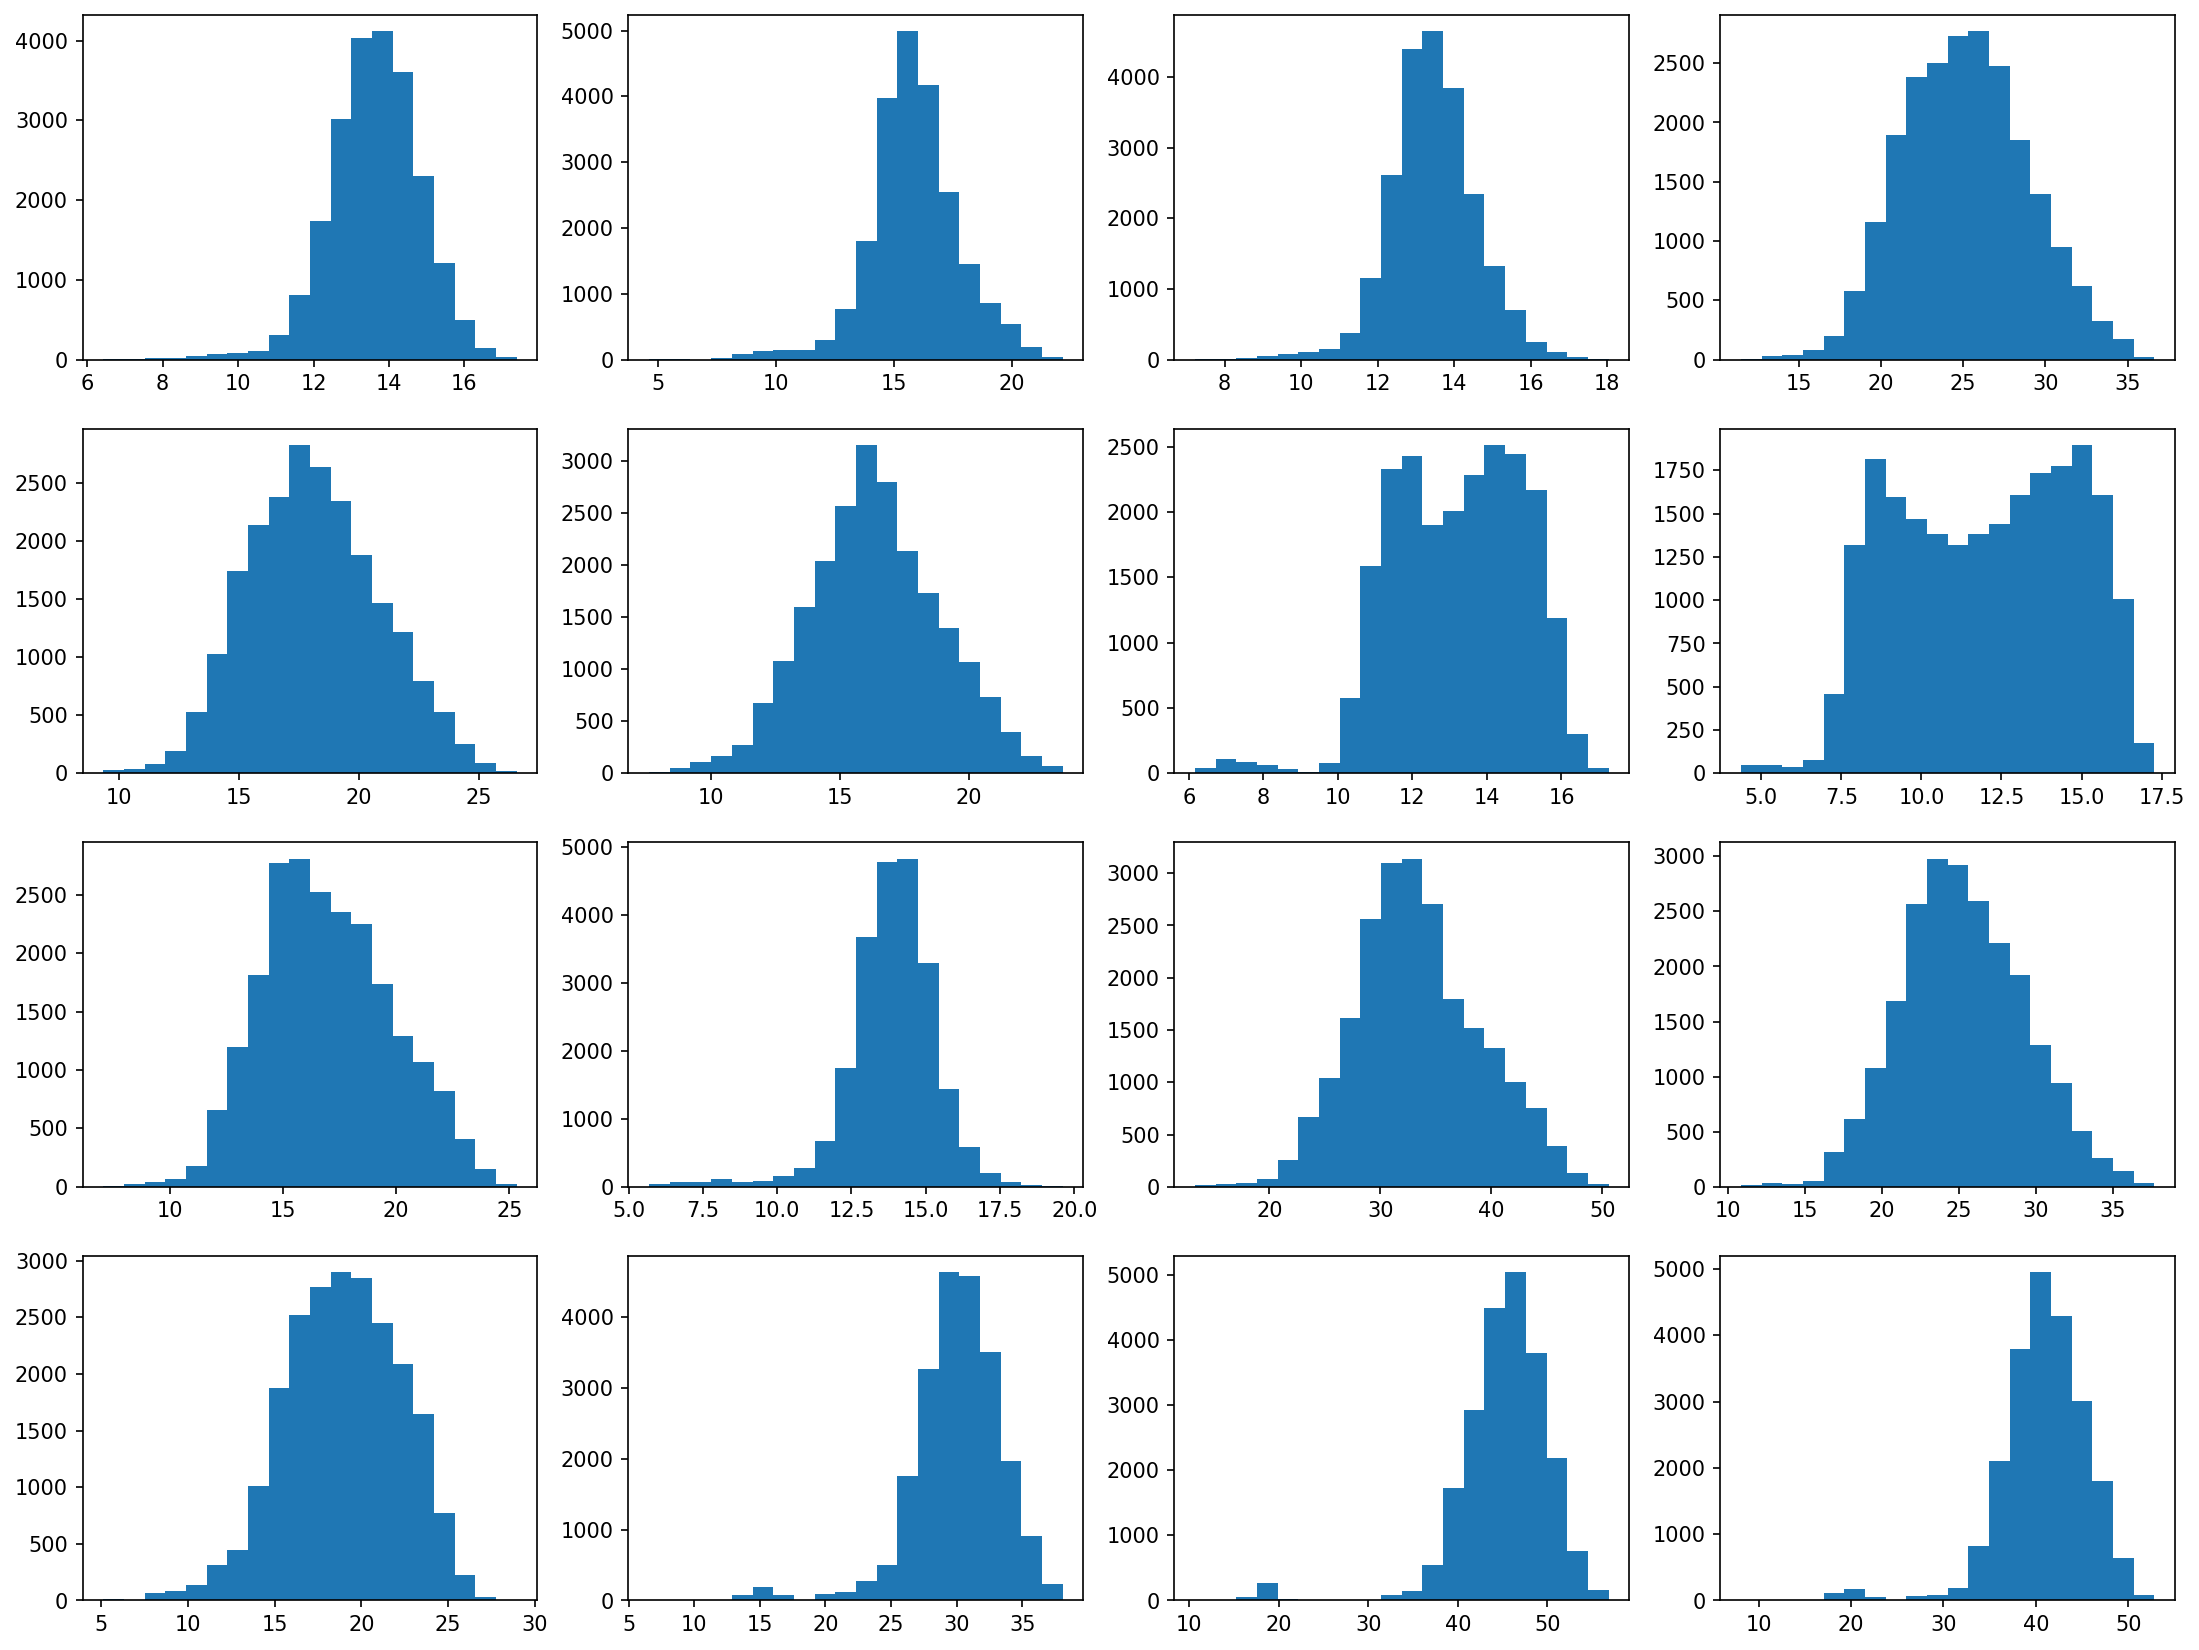

In [306]:
# generate distance histograms
# plt.title('Distance Distribution Per Head', fontsize=18)
fig = plt.figure(0)
# fig.suptitle('This is a somewhat long figure title', fontsize=16)
plt.subplots(figsize=(18, 14), dpi = 150)
to_display_heads = 4
to_display_layers = 4
for i in range(to_display_heads):
    for j in range(to_display_layers):
        ax = plt.subplot2grid((to_display_heads, to_display_layers), (i, j))
        ax.hist(all_dist[i][j], bins = 20)
plt.show()

<Figure size 432x288 with 0 Axes>

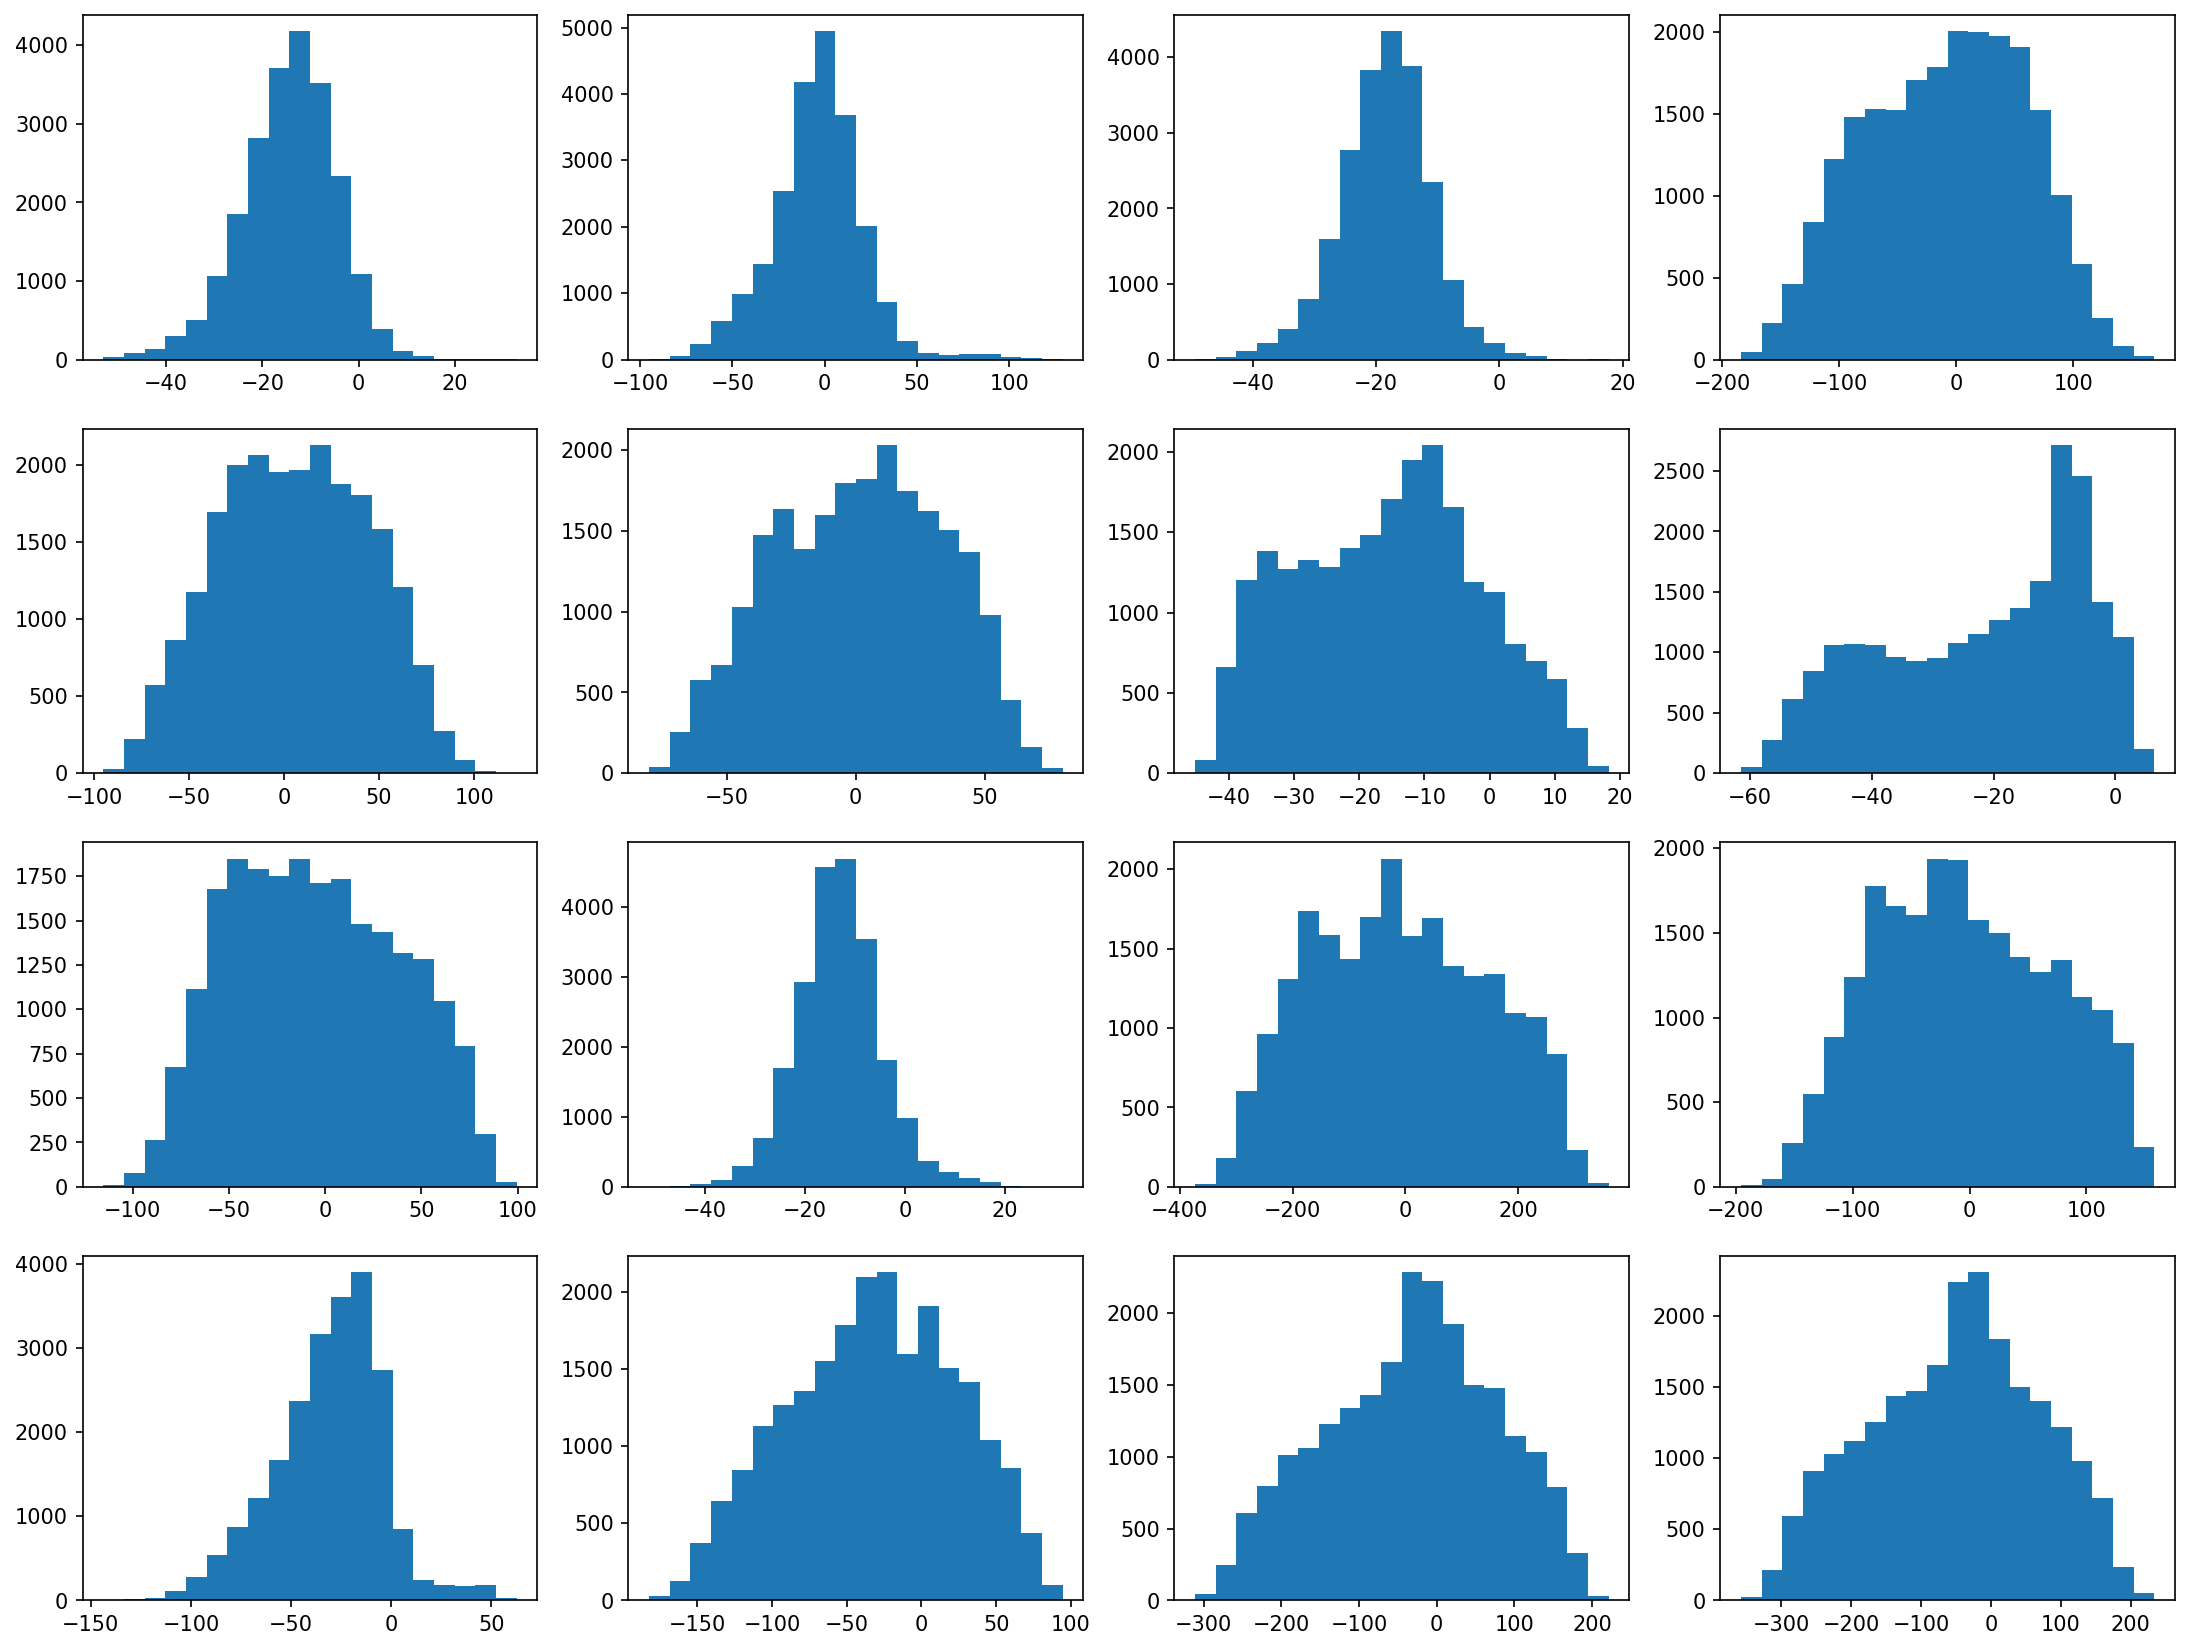

In [305]:
# generate dot product histograms
fig = plt.figure(0)
plt.subplots(figsize=(18, 14), dpi = 150)
to_display_heads = 4
to_display_layers = 4
for i in range(to_display_heads):
    for j in range(to_display_layers):
        ax = plt.subplot2grid((to_display_heads, to_display_layers), (i, j))
        ax.hist(all_dp[i][j], bins = 20)
plt.show()

In [7]:
# Query key norms
scaling_consts = [1]
# all_dp = [[list() for i in range(num_heads)] for j in range(num_layers)]
# all_dist = [[list() for i in range(num_heads)] for j in range(num_layers)]

sample_dp = []
sample_dist = []

for scale in scaling_consts:
    token_count = 0    
    for s in sentences[0:1]:
        s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
        
        for i in range(1, 2):
            for j in range(1, 2):
                query = s_dict['queries'][i][j]
                key = s_dict['keys'][i][j]

                for q in query:
#                     dp_scaled = []
#                     dist_scaled = []
                    for k in key:
                        # compute scaled q + k
#                         print(q)
                        q_scaled = [x / scale for x in q]
                        k_scaled = [x * scale for x in k]
                        
                        # compute dp + distance
                        sample_dp.append(np.dot(q_scaled, k_scaled))
                        sample_dist.append(distance(q_scaled, k_scaled))

Text(0, 0.5, 'Distance')

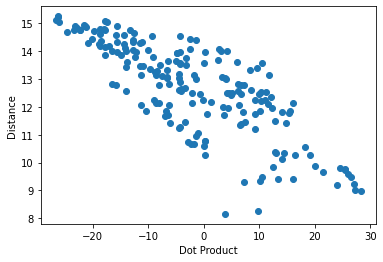

In [42]:
plt.scatter(sample_dp, sample_dist)
plt.xlabel('Dot Product')
plt.ylabel('Distance')

### Experimenting with different correlation measures / thresholding

In [47]:
# source: https://stackoverflow.com/questions/38641691/weighted-correlation-coefficient-with-pandas
# another resource: https://stats.stackexchange.com/questions/221246/such-thing-as-a-weighted-correlation

def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def weighted_corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [51]:
## Thresholding
corr_scaling = [[defaultdict(float) for i in range(num_heads)] for j in range(num_layers)]
# scaling_consts = [0.1, 0.2, 0.4, 0.6, 0.8, 1, 1/0.8, 1/0.6, 1/0.4, 1/0.2]
scaling_consts = [0.1, 0.4, 0.8, 1, 1/0.8, 1/0.4, 1/0.1]
# scaling_consts = [0.01, 0.1]
import math

counter = 0
for scale in scaling_consts:
    token_count = 0
    
    for s in sentences[0:5]:
        s_dict = neuron_view.get_attention(model, model_type, tokenizer, s, include_queries_and_keys=True)['all']
        
        for i in range(1): # range(num_heads):
            for j in range(1): # range(num_layers):
                query = s_dict['queries'][i][j]
                key = s_dict['keys'][i][j]

                for q in query:
                    dp_scaled = []
                    dist_scaled = []
                    for k in key:
                        # compute scaled q + k
                        q_scaled = [x / scale for x in q]
                        k_scaled = [x * scale for x in k]
                        
                        # compute dp + distance
                        d = distance(q_scaled, k_scaled)
                        if d < 10: # How to determine this threshold?
                            counter += 1
                            dp_scaled.append(np.dot(q_scaled, k_scaled))
                            dist_scaled.append(distance(q_scaled, k_scaled))
                
                    # compute correlation
                    if len(dp_scaled) > 1:
                        corr_scaling[i][j][scale] += np.corrcoef(dp_scaled, dist_scaled)[0][1]
                        if np.isnan(np.corrcoef(dp_scaled, dist_scaled)[0][1]):
                            print(len(dp_scaled))
                        token_count += 1
        
    if token_count > 0:
        print(token_count)
        for i in range(num_heads):
            for j in range(num_layers):
                corr_scaling[i][j][scale] = corr_scaling[i][j][scale] /token_count #* (num_heads * num_layers)

21
2


In [52]:
corr_scaling[0][0]

defaultdict(float, {0.8: 0.2847365287034781, 1: 5.551115123125783e-17})